# TFM: Predicción de la demanda energética - Parte 4: Serie temporal de consumo total de cada una de las provincias (CU 2)
#### Lara Palacios

En este caso de uso, vamos a analizar la serie temporal del consumo total de cada una de las provincias. Seleccionaremos una provincia en concreto a estudiar.

## 0. Importación de librerías

In [1]:
!pip install skforecast

In [2]:
!pip install pmdarima

In [3]:
!pip install shap

In [4]:
!pip install prophet

In [5]:
import pandas as pd
import numpy as np
import json
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from io import StringIO
import contextlib
import re
import gc
import warnings
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster, bayesian_search_forecaster, grid_search_forecaster
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax, grid_search_sarimax

from pmdarima import ARIMA
from pmdarima import auto_arima

from lightgbm import LGBMRegressor
import plotly.graph_objects as go

import shap

from prophet import Prophet

pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

## 3. Preparación de los datos

En este cuaderno trabajaremos solo con la serie temporal de la variable CONSUMO:

In [6]:
variable = 'CONSUMO'

### 3.2. Integridad de la serie temporal

#### 3.2.0. Carga de los datos

In [7]:
#conexión a google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df_preprocesado = pd.read_parquet('/content/drive/MyDrive/TFM/df_preprocesado_red.parquet')
df_preprocesado.shape

(15140750, 26)

In [9]:
seleccionar_clientes = pd.read_parquet('/content/drive/MyDrive/TFM/seleccionar_clientes.parquet')
seleccionar_clientes.shape

(11137, 4)

Añadiendo condiciones sobre el dataframe 'seleccionar_clientes' podemos descartar a clientes que no cumplan condiciones de integridad.

In [10]:
filtro_clientes = seleccionar_clientes[(seleccionar_clientes['FILAS_NA'] == 0) & (seleccionar_clientes['INICIO'] == seleccionar_clientes['INICIO'].min())].reset_index(drop = True)
filtro_clientes.shape

(9781, 4)

In [11]:
df = df_preprocesado[df_preprocesado['PK_CLIENTE'].isin(filtro_clientes['PK_CLIENTE'])]
df.shape

(13510134, 26)

In [12]:
#para liberar espacio de la RAM en Google Colab
del filtro_clientes
gc.collect()
filtro_clientes=pd.DataFrame()

#### 3.2.1. Formato de serie temporal

Veamos cuantos datos de clientes distintos tenemos para cada día de la serie. Así aseguraremos que tenemos una serie con las mismas condiciones en cada día.

In [13]:
clientes_por_fecha = df.groupby(df.PK_ANYOMESDIA).agg({'PK_CLIENTE': 'nunique'}).rename(columns={'PK_CLIENTE': 'count_PK_CLIENTE'}).reset_index()
clientes_por_fecha['PK_ANYOMESDIA'] = clientes_por_fecha['PK_ANYOMESDIA'].dt.date

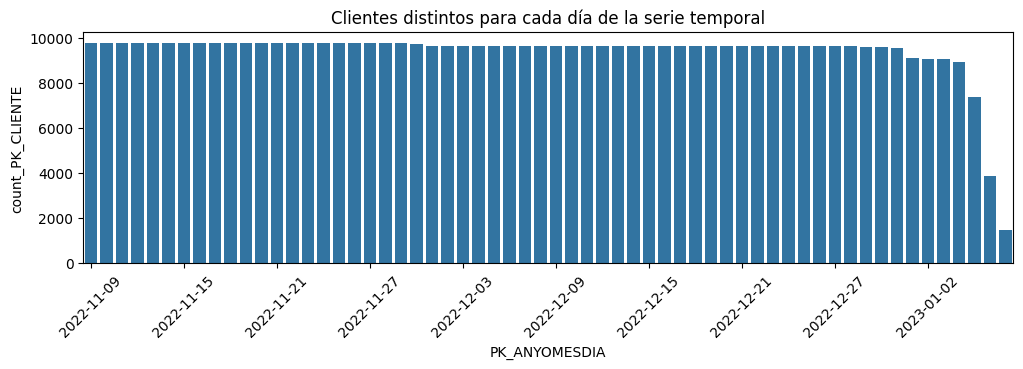

In [14]:
plt.figure(figsize=(12, 3))
sns.barplot(x = "PK_ANYOMESDIA", y = "count_PK_CLIENTE", data = clientes_por_fecha)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
plt.title('Clientes distintos para cada día de la serie temporal')
plt.show()

Vemos que para los últimos días se reduce notablemente el número de clientes para los que tenemos datos. Calculamos los outliers de nuevo con el método del rango intercuartílico y así los eliminamos de nuestra serie temporal.

In [15]:
Q1 = clientes_por_fecha['count_PK_CLIENTE'].quantile(0.25)
Q3 = clientes_por_fecha['count_PK_CLIENTE'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

df_filtrado = clientes_por_fecha[(clientes_por_fecha['count_PK_CLIENTE'] >= limite_inferior) & (clientes_por_fecha['count_PK_CLIENTE'] <= limite_superior)]
fecha_min = df_filtrado['PK_ANYOMESDIA'].min()
fecha_max = df_filtrado['PK_ANYOMESDIA'].max()

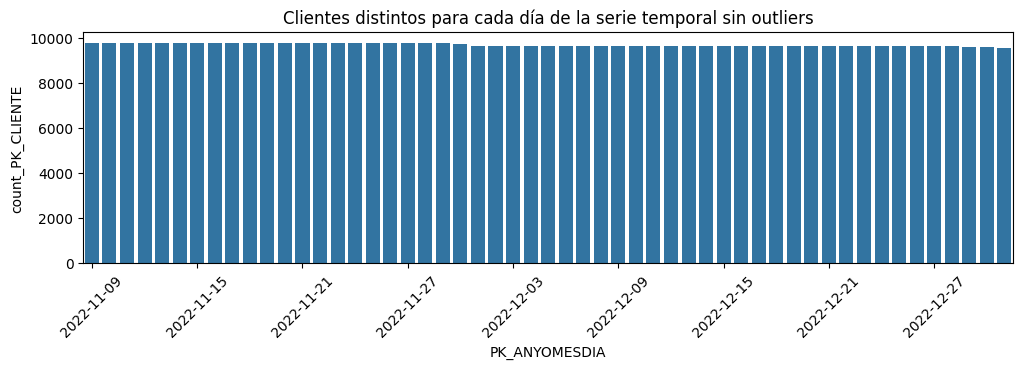

In [16]:
plt.figure(figsize=(12, 3))
sns.barplot(x = "PK_ANYOMESDIA", y = "count_PK_CLIENTE", data = df_filtrado)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
plt.title('Clientes distintos para cada día de la serie temporal sin outliers')
plt.show()

In [17]:
#para liberar espacio de la RAM en Google Colab
del df_filtrado
gc.collect()
df_filtrado=pd.DataFrame()

Así pues, consideraremos solo estos días en nuestra serie temporal del consumo total de la red de clientes. Además, también nos quedamos solo con los clientes que tengan datos para todos estos días.

In [18]:
filtro_clientes_2 = seleccionar_clientes[(seleccionar_clientes['FILAS_NA'] == 0) & (seleccionar_clientes['INICIO'] == seleccionar_clientes['INICIO'].min()) & (seleccionar_clientes['FIN'].dt.date > fecha_max)].reset_index(drop = True)
df = df_preprocesado[df_preprocesado['PK_CLIENTE'].isin(filtro_clientes_2['PK_CLIENTE'])]
df = df[(df['DATETIME'].dt.date >= fecha_min) & (df['DATETIME'].dt.date <= fecha_max)]
df.shape

(11605728, 26)

In [19]:
#para liberar espacio de la RAM en Google Colab
del df_preprocesado
gc.collect()
df_preprocesado=pd.DataFrame()

In [20]:
#para liberar espacio de la RAM en Google Colab
del filtro_clientes_2
gc.collect()
filtro_clientes_2=pd.DataFrame()

Veamos cuantos datos de clientes distintos tenemos para cada día de la serie. Así aseguraremos que tenemos una serie con las mismas condiciones en cada día.

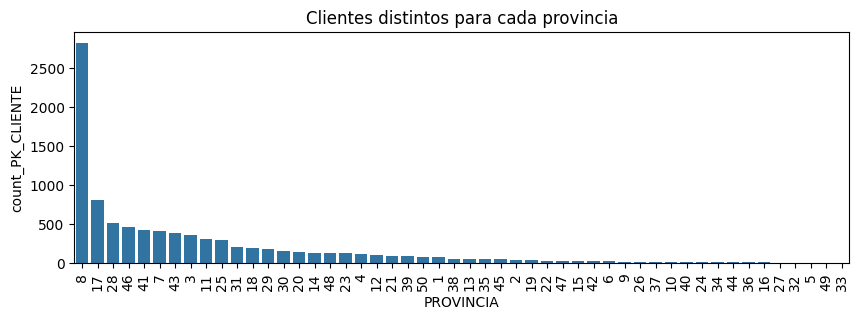

In [21]:
clientes_por_provincia = df.groupby(df.PROVINCIA).agg({'PK_CLIENTE': 'nunique'}).rename(columns={'PK_CLIENTE': 'count_PK_CLIENTE'}).reset_index()
clientes_por_provincia = clientes_por_provincia.sort_values(by="count_PK_CLIENTE", ascending=False)
order = clientes_por_provincia["PROVINCIA"]
plt.figure(figsize=(10, 3))
sns.barplot(x="PROVINCIA", y="count_PK_CLIENTE", data=clientes_por_provincia, order=order)
plt.xticks(rotation=90)
plt.title('Clientes distintos para cada provincia')
plt.show()

Seleccionamos alguna variable más que luego nos servirá para añadir como variable exógena al modelo predictivo:

In [22]:
df['ORTO_minutos'] = df['ORTO'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['OCASO_minutos'] = df['OCASO'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
df['%_CIELO_DESPEJADO'] = np.where(df['DESCRIPCION'] == 'Despejado',100,0)

Y creamos una serie temporal para cada provincia:

In [23]:
df_consumo_total_por_provincia = {}

for p in df['PROVINCIA'].unique():
    df_provincia = df[df['PROVINCIA'] == p]
    df_consumo_total = df_provincia.groupby(['DATETIME']).agg({variable: 'mean','TEMPERATURA': 'mean',
        '%_CIELO_DESPEJADO': 'mean','ORTO_minutos': 'mean','OCASO_minutos': 'mean'})
    df_consumo_total = df_consumo_total.asfreq('H')
    df_consumo_total_por_provincia[p] = df_consumo_total

In [24]:
df_consumo_total_por_provincia[17].head()

CONSUMO  TEMPERATURA  %_CIELO_DESPEJADO  ORTO_minutos  \
DATETIME                                                                      
2022-11-09 00:00:00  0.597356    14.579728                0.0    449.960445   
2022-11-09 01:00:00  0.548960    14.254635                0.0    449.960445   
2022-11-09 02:00:00  0.528614    14.804697                0.0    449.960445   
2022-11-09 03:00:00  0.513141    14.257108                0.0    449.960445   
2022-11-09 04:00:00  0.479022    13.877627                0.0    449.960445   

                     OCASO_minutos  
DATETIME                            
2022-11-09 00:00:00    1053.148331  
2022-11-09 01:00:00    1053.148331  
2022-11-09 02:00:00    1053.148331  
2022-11-09 03:00:00    1053.148331  
2022-11-09 04:00:00    1053.148331

In [25]:
#para liberar espacio de la RAM en Google Colab
del df
gc.collect()
df=pd.DataFrame()

Con el agrupamiento por la columna DATETIME, ya se establece esta como índice (que es lo que nos interesa). Esta tarea nos facilitará a la hora de hacer futuras operaciones con ella.

Comprobamos ahora que nuestra serie temporal está completa:

In [26]:
results = {}

for p, df in df_consumo_total_por_provincia.items():
    is_continuous = (df.index == pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')).all()
    missing_values_mean = df.isnull().any(axis=1).mean()
    if (is_continuous != True) | (missing_values_mean != 0.0):
      print(p)

Ahora seleccionamos la serie temporal de la provincia del cliente que habíamos estudiado en el caso de uso 2.


In [27]:
df_consumo_total = df_consumo_total_por_provincia[17]

#### 3.2.2. Variables exógenas

Podemos introducir otras variables de las cuáles podría depender también el consumo de un hogar, y que se incluyen típicamente en análisis de series temporales como son: el día de la semana y el indicador de si es fin de semana o no.
Las usaremos más adelante para cuando queramos incluir variables exógenas a nuestros modelos predictivos.

In [28]:
def minutos_a_formato_h(var_minutos):
    horas = int(var_minutos // 60)
    minutos = int(var_minutos % 60)
    var_formateada = f"{horas:02d}:{minutos:02d}"
    var_formateada = pd.to_datetime(var_formateada, format='%H:%M').hour
    return var_formateada

In [29]:
#variables de calendario
df_consumo_total['HORA'] = df_consumo_total.index.hour #+1
df_consumo_total['DIA_SEMANA'] = df_consumo_total.index.dayofweek #+1
df_consumo_total['FIN_DE_SEMANA'] = (df_consumo_total['DIA_SEMANA'] >= 5).astype(int)
#variables de luz solar
df_consumo_total['H_LUZ_SOLAR'] = (df_consumo_total['OCASO_minutos'] - df_consumo_total['ORTO_minutos'])
df_consumo_total['H_LUZ_SOLAR'] = df_consumo_total['H_LUZ_SOLAR'].apply(minutos_a_formato_h)
df_consumo_total['ORTO'] = df_consumo_total['ORTO_minutos'].apply(minutos_a_formato_h)
df_consumo_total['OCASO'] = df_consumo_total['OCASO_minutos'].apply(minutos_a_formato_h)
df_consumo_total["ES_DE_DIA"] = np.where((df_consumo_total.index.hour>df_consumo_total["ORTO"]) & (df_consumo_total.index.hour<df_consumo_total["OCASO"]),1,0)
df_consumo_total = df_consumo_total.drop(columns = ['OCASO_minutos', 'ORTO_minutos'])

In [30]:
df_consumo_total.head()

CONSUMO  TEMPERATURA  %_CIELO_DESPEJADO  HORA  \
DATETIME                                                              
2022-11-09 00:00:00  0.597356    14.579728                0.0     0   
2022-11-09 01:00:00  0.548960    14.254635                0.0     1   
2022-11-09 02:00:00  0.528614    14.804697                0.0     2   
2022-11-09 03:00:00  0.513141    14.257108                0.0     3   
2022-11-09 04:00:00  0.479022    13.877627                0.0     4   

                     DIA_SEMANA  FIN_DE_SEMANA  H_LUZ_SOLAR  ORTO  OCASO  \
DATETIME                                                                   
2022-11-09 00:00:00           2              0           10     7     17   
2022-11-09 01:00:00           2              0           10     7     17   
2022-11-09 02:00:00           2              0           10     7     17   
2022-11-09 03:00:00           2              0           10     7     17   
2022-11-09 04:00:00           2              0           10     7     17   

                     ES_DE_DIA  
DATETIME                        
2022-11-09 00:00:00          0  
2022-11-09 01:00:00          0  
2022-11-09 02:00:00          0  
2022-11-09 03:00:00          0  
2022-11-09 04:00:00          0

In [31]:
#Crear dataframe variables exógenas
exog_cols = ['TEMPERATURA', '%_CIELO_DESPEJADO', 'FIN_DE_SEMANA', 'H_LUZ_SOLAR', 'ES_DE_DIA']

Una vez tenemos ya extraídas todas las variables exógenas que nos interesan, hagamos algunos pasos adicionales.

##### Variables con patrones cíclicos

Algunos aspectos del calendario, como las horas o los días, son cíclicos. Así, este tipo de variables pueden transformarse para captar la ciclicidad de estos datos, utilizando el seno y el coseno de su periodo, y evitar imponer un orden lineal.

In [32]:
def codificacion_ciclica(datos, longitud_ciclo): #Se asume que el valor mínimo de la variable es 0
    seno = np.sin(2 * np.pi * datos/longitud_ciclo)
    coseno = np.cos(2 * np.pi * datos/longitud_ciclo)
    resultado =  pd.DataFrame({f"{datos.name}_seno": seno, f"{datos.name}_coseno": coseno})
    return resultado

DIA_SEMANA_encoded = codificacion_ciclica(df_consumo_total['DIA_SEMANA'], longitud_ciclo=7)
HORA_encoded = codificacion_ciclica(df_consumo_total['HORA'], longitud_ciclo=24)
ORTO_encoded = codificacion_ciclica(df_consumo_total['ORTO'], longitud_ciclo=24)
OCASO_encoded = codificacion_ciclica(df_consumo_total['OCASO'], longitud_ciclo=24)
variables_ciclicas = pd.concat([DIA_SEMANA_encoded, HORA_encoded,ORTO_encoded,OCASO_encoded], axis=1)
df_consumo_total = pd.concat([df_consumo_total, variables_ciclicas], axis=1)

In [33]:
exog_cols.extend(df_consumo_total.filter(regex='_seno$|_coseno$').columns.tolist())

##### Interacción entre variables

En ocasiones, las variables exógenas no son independientes. Podemos capturar esta interacción mediante nuevas variables (que se obtienen multiplicando entre sí las variables existentes).

In [34]:
transformer_poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False).set_output(transform="pandas")
poly_cols = ['FIN_DE_SEMANA','DIA_SEMANA_seno','DIA_SEMANA_coseno','HORA_seno','HORA_coseno','H_LUZ_SOLAR','ES_DE_DIA','ORTO_seno','ORTO_coseno','OCASO_seno','OCASO_coseno']

variables_poly = transformer_poly.fit_transform(df_consumo_total[poly_cols].dropna()).drop(columns=poly_cols)
variables_poly.columns = [f"poly_{col}" for col in variables_poly.columns]
variables_poly.columns = variables_poly.columns.str.replace(" ", "__")
df_consumo_total = pd.concat([df_consumo_total, variables_poly], axis=1)

In [35]:
exog_cols.extend(df_consumo_total.filter(regex='^poly_.*').columns.tolist())

In [36]:
#eliminar columna DIA

#### 3.2.3. Separación de los datos en conjuntos de train, validation y test
Para poder optimizar los hiperparámetros del modelo y evaluar su capacidad predictiva, se dividen los datos en 3 conjuntos, uno de entrenamiento, uno de validación y otro de test.

Notar que en el caso de series temporales no hay que aislar la variable target del resto, pues los valores pasados de esta variable se utilizan para su predicción.

In [37]:
df_consumo_total['DIA'] = df_consumo_total.index.date
dias = df_consumo_total['DIA'].unique()
n_dias = len(dias)

dias_train = int(n_dias * 0.6)
dias_validation = int(n_dias * 0.3)
dias_test = n_dias - dias_train - dias_validation

train_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[:dias_train])]
validation_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[dias_train:dias_train + dias_validation])]
test_data = df_consumo_total[df_consumo_total['DIA'].isin(dias[dias_train + dias_validation:])]

print("---Serie temporal del consumo total de la red de clientes---")
print(f"Fechas train      : {train_data.index.min()} --- {train_data.index.max()}  (n={len(train_data)})")
print(f"Fechas validacion : {validation_data.index.min()} --- {validation_data.index.max()}  (n={len(validation_data)})")
print(f"Fechas test       : {test_data.index.min()} --- {test_data.index.max()}  (n={len(test_data)})")

---Serie temporal del consumo total de la red de clientes---
Fechas train      : 2022-11-09 00:00:00 --- 2022-12-09 23:00:00  (n=744)
Fechas validacion : 2022-12-10 00:00:00 --- 2022-12-24 23:00:00  (n=360)
Fechas test       : 2022-12-25 00:00:00 --- 2022-12-31 23:00:00  (n=168)


## 4. Exploración gráfica

### 4.1. Representación gráfica de la serie temporal

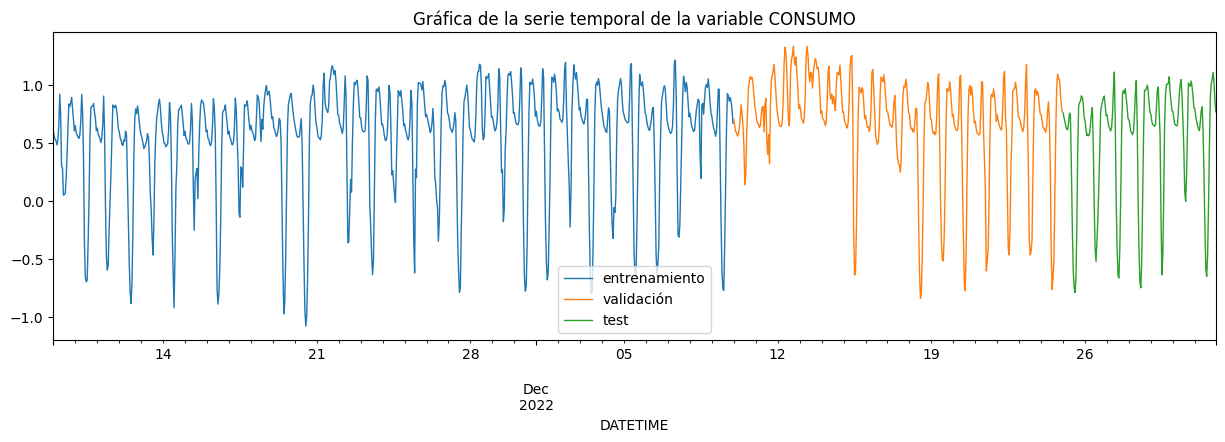

In [38]:
fig, ax = plt.subplots(figsize=(15, 4))
train_data[variable].plot(ax=ax, label= 'entrenamiento', linewidth=1)
validation_data[variable].plot(ax=ax, label= 'validación', linewidth=1)
test_data[variable].plot(ax=ax, label= 'test', linewidth=1)
ax.set_title(f'Gráfica de la serie temporal de la variable {variable}')
ax.legend()

### 4.2. Distribución de la carga por día de la semana

Text(0.5, 0.98, '')

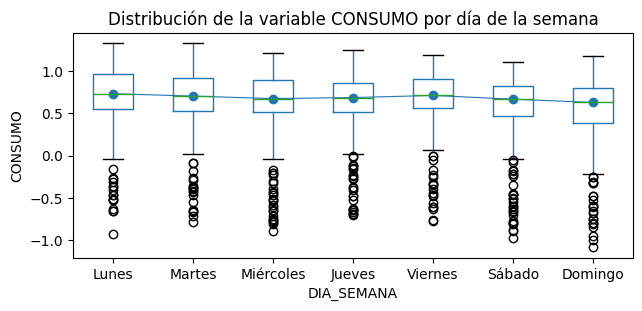

In [39]:
fig, ax = plt.subplots(figsize=(7, 3))
df_consumo_total.boxplot(column=variable, by='DIA_SEMANA', ax=ax, grid=False)
medianas = df_consumo_total.groupby('DIA_SEMANA')[variable].median()
medianas.index = medianas.index + 1
medianas.plot(style='o-', linewidth=0.8, ax=ax)
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
plt.xticks(ticks=range(1,8), labels=dias_semana)
ax.set_ylabel(variable)
ax.set_title(f'Distribución de la variable {variable} por día de la semana')
fig.suptitle('')

### 4.3. Distribución de la carga por hora del día

Text(0.5, 0.98, '')

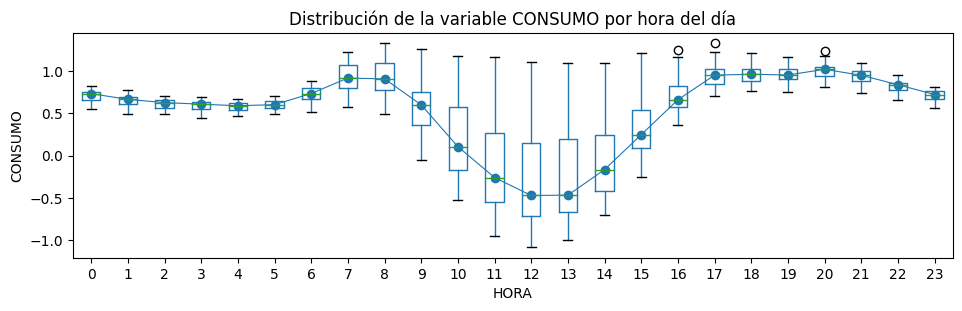

In [40]:
fig, ax = plt.subplots(figsize=(11, 3))
df_consumo_total['HORA'] = df_consumo_total.index.hour
df_consumo_total.boxplot(column=variable, by='HORA', ax=ax)
medianas = df_consumo_total.groupby('HORA')[variable].median()
medianas.index = medianas.index + 1
medianas.plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel(variable)
ax.set_title(f'Distribución de la variable {variable} por hora del día')
fig.suptitle('')

## 5. Creación y entrenamiento del modelo

### 5.0. Definición de funciones necesarias

In [41]:
train_val_data = pd.concat([train_data, validation_data], axis=0)

In [42]:
tabla_comparacion_modelos = pd.DataFrame(columns=['Modelo', 'Tiempo de ejecución', 'Variables exógenas', 'refit', 'MAE', 'MSE', 'RMSE'])

def guardar_results(modelo, tiempo, mae, mse, rmse, tabla_comparacion_modelos, var_exog = 'No', refit = 'No'):
  tabla_comparacion_modelos = pd.concat([tabla_comparacion_modelos, pd.DataFrame({'Modelo': modelo, 'Tiempo de ejecución': tiempo, 'Variables exógenas': var_exog, 'refit': refit, 'MAE': mae.round(1), 'MSE': mse.round(1), 'RMSE': rmse.round(1)}, index=[0])], ignore_index=True)
  return tabla_comparacion_modelos

In [43]:
def all_metrics(prediccion, test_data):
    metrics = {}
    metrics['MAE'] = mean_absolute_error(test_data[variable], prediccion)
    metrics['MSE'] = mean_squared_error(test_data[variable], prediccion)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    return metrics

In [88]:
def backtesting(forecaster, df, train_data, test_data, grafica = True, refit = False, exog_cols = None):
    inicio = time.time()

    if exog_cols is not None:
        exog = df[exog_cols]
    else:
        exog = None
    if refit == False:
      fixed_train_size = True
    elif refit == True:
      fixed_train_size = False
    params = {
        'forecaster': forecaster,
        'y': df[variable],
        'exog': exog,
        'steps': 24,
        'metric': 'mean_absolute_error',
        'initial_train_size': len(df[variable].loc[:train_data.index.max()]),
        'n_jobs': 'auto',
        'verbose': False,
        'show_progress': True,
        'fixed_train_size': fixed_train_size,
        'refit': refit
    }
    if isinstance(forecaster, ForecasterSarimax):
        metric, predictions = backtesting_sarimax(**params)
    else:
        metric, predictions = backtesting_forecaster(**params)

    fin = time.time()
    tiempo = fin-inicio
    print(f"Tiempo de ejecución: {tiempo}")

    metrics = all_metrics(predictions, test_data)
    print(f"Métricas de error: {metrics}")

    if grafica == True:
      fig, ax = plt.subplots(figsize=(11, 3))
      train_data[variable].plot(ax=ax, label='train', color = '#1f77b4')
      # color para el de validación '#ff7f0e'
      test_data[variable].plot(ax=ax, label='test', color = '#2ca02c')
      predictions.plot(ax=ax, label='predicciones', color = '#FF0000')
      ax.set_title(f'Predicción sobre la variable {variable}')
      ax.legend()

    print("--------------------------------")
    return metrics, tiempo, predictions

In [45]:
def importancia_features(forecaster, df, train_data):
  forecaster.fit(y = df.loc[:train_data.index.max(), variable], exog = df.loc[:train_data.index.max(), exog_cols])
  feature_importances = forecaster.get_feature_importances()
  feature_importances['%_importance'] = ((feature_importances['importance'] / feature_importances['importance'].sum()) * 100).round(2)
  feature_importances = feature_importances.sort_values(by='%_importance', ascending=False).head(10).reset_index(drop = True).drop(columns = ['importance'])
  return feature_importances

In [46]:
def shap_values(forecaster, train_data):
  X_train, y_train = forecaster.create_train_X_y(y=train_val_data[variable]) # Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor

  params = forecaster.regressor.get_params()
  params['predict_disable_shape_check'] = True
  forecaster.regressor = LGBMRegressor(**params)
  forecaster.regressor.fit(X_train, y_train)

  explainer = shap.TreeExplainer(forecaster.regressor)
  # Se selecciona una muestra del 50% de los datos para acelerar el cálculo
  rng = np.random.default_rng(seed=785412)
  sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
  X_train_sample = X_train.loc[sample, :]
  shap_values = explainer.shap_values(X_train_sample)

  shap.initjs()
  shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
  fig, ax = plt.gcf(), plt.gca()
  ax.set_title("SHAP Summary plot")
  ax.tick_params(labelsize=8)
  fig.set_size_inches(6, 3.5)
  plt.show()

### 5.1. Baseline

La librería *Skforecast* facilita la creación de un baseline utilizando su clase *ForecasterEquivalentDate*. Este modelo simplemente devuelve el valor observado en el mismo período de la temporada anterior. En este caso, el modelo predice el valor del día siguiente utilizando el valor de la misma hora y del mismo día de la semana anterior.

Una vez entrenado el modelo, evaluaremos su capacidad predictiva mediante un proceso de backtesting.

In [47]:
params = {
    'offset': pd.DateOffset(days=7),
    'n_offsets': 1
}
baseline = ForecasterEquivalentDate(**params)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.17934751510620117
Métricas de error: {'MAE': 0.09001759962328565, 'MSE': 0.02753863867558526, 'RMSE': 0.16594769861491077}
--------------------------------


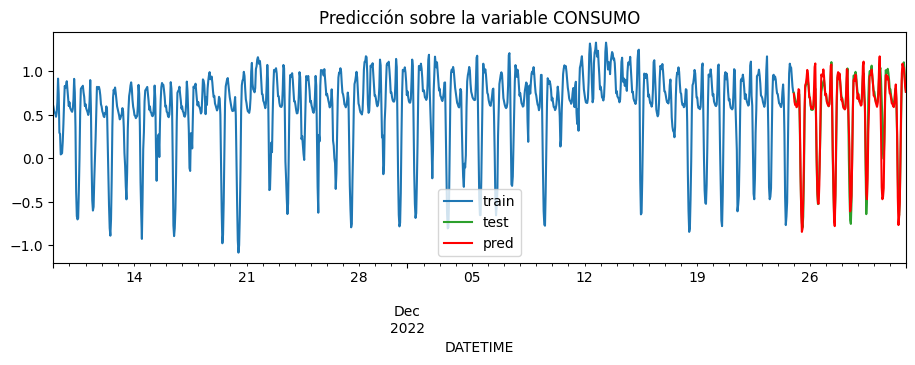

In [48]:
metrics, tiempo = backtesting(baseline, df_consumo_total, train_val_data, test_data)
tabla_comparacion_modelos = guardar_results(f'ForecasterEquivalentDate({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

Una vez tenemos un baseline, probemos a modelar la serie mediante un tipo de modelo estadístico muy usado para series temporales: ARIMA y sus variantes.

### 5.2. ARIMA (AutoRegressive Integrated Moving Average)

#### 5.2.1. Análisis exploratorio de la serie

Antes de aplicar ARIMA, es necesario:

1. **Verificar Estacionariedad**

Observando la gráfica de la serie temporal, parece que la media y la varianza permanencen más o menos constantes, lo cuál es un indicador de estacionaridad. Pero para asegurarnos, aplicaremos la prueba de **Dickey Fuller aumentada** y la de **Kwiatkowski-Phillips-Schmidt-Shin (KPSS)**.

In [49]:
def test_estacionariedad(df): ## tengo dudas sobre si esto se aplica sobre todo el conjunto o solo sobre el de train
    print(f'Test estacionariedad para la serie de la variable {variable}')
    print('--------------------------------------------------------------')
    adfuller_result = adfuller(df[variable])
    kpss_result = kpss(df[variable])
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

In [50]:
test_estacionariedad(train_val_data)

Test estacionariedad para la serie de la variable CONSUMO
--------------------------------------------------------------
ADF Statistic: -2.9379945593576906, p-value: 0.04110479508154497
KPSS Statistic: 0.8832896363835765, p-value: 0.01


Notar que para la prueba DF el p-value > 0.05 y para la de KPSS el p-value < 0.05, luego se considera que la serie es estacionarias y es necesario diferenciar.

In [51]:
train_data_diff_1 = train_val_data.diff().dropna()

In [52]:
test_estacionariedad(train_data_diff_1)

Test estacionariedad para la serie de la variable CONSUMO
--------------------------------------------------------------
ADF Statistic: -15.068808444678567, p-value: 8.785719282104966e-28
KPSS Statistic: 0.006214680195913723, p-value: 0.1


Ahora los valores de los p-values si que están en el umbral que deben estar. Por lo tanto:

In [53]:
d = 1

Pintemos las gráficas de las series diferenciadas:

<Axes: title={'center': 'Diferenciación de orden 1 de la serie de la variable CONSUMO'}, xlabel='DATETIME'>

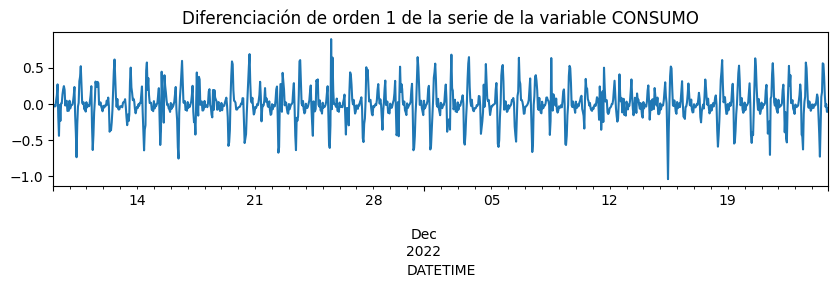

In [54]:
fig, ax = plt.subplots(figsize=(10, 2))
train_data_diff_1[variable].plot(ax=ax, title=f'Diferenciación de orden 1 de la serie de la variable {variable}')

Los análisis posteriores debemos realizarlos con la serie diferenciada.

2. **Análisis de autocorrelación**

La ACF ayuda a identificar el valor de $q$ (lags en la parte de media móvil), mientras que la PACF ayuda a identificar el valor de $p$ (lags en la parte autorregresiva).

- El umbral de significancia en un gráfico de autocorrelación se refiere a las líneas horizontales que se dibujan a una distancia de ±1.96/√n (donde n es el número de observaciones) alrededor del valor cero. Estas líneas delimitan una región donde los valores de autocorrelación se consideran no significativamente diferentes de cero. Así, los valores que se encuentran dentro de estas líneas se consideran ruido blanco, es decir, no proporcionan información útil sobre la estructura de la serie temporal.

- Se dice que la función de autocorrelación corta significativamente en el lag i, cuando el valor de la autocorrelación en el lag i está fuera del umbral de significancia.

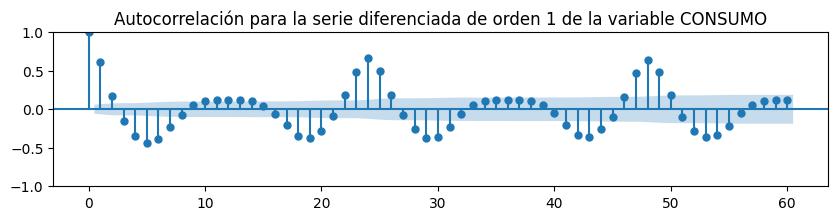

In [55]:
fig, ax = plt.subplots(figsize=(10, 2))

plot_acf(train_data_diff_1[variable], ax=ax, lags=60)
ax.set_title(f'Autocorrelación para la serie diferenciada de orden 1 de la variable {variable}')
plt.show()

La ACF muestra un patrón sinusoidal, lo cual podría indicar la presencia de una componente estacional. Las correlaciones significativas a múltiples lags indican que hay una dependencia temporal a lo largo del tiempo.

El lag en el que la ACF cruza el umbral de significancia proporciona una estimación del valor de $q$:

In [56]:
q = 3

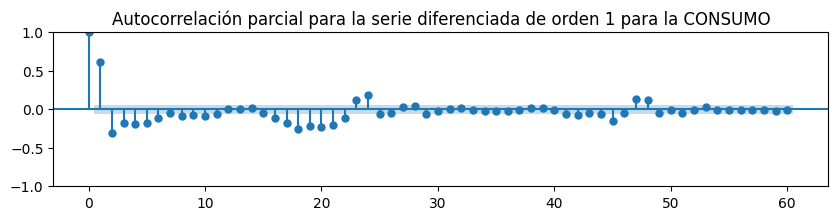

In [57]:
fig, ax = plt.subplots(figsize=(10, 2))
plot_pacf(train_data_diff_1[variable], ax=ax, lags=60, method='ywm')
ax.set_title(f'Autocorrelación parcial para la serie diferenciada de orden 1 para la {variable}')
plt.show()

En la gráfica de autocorrelación parcial (PACF), los primeros lags muestran correlaciones significativas, lo cual indica que hay una relación directa entre los valores actuales y los valores pasados en esos lags específicos.
Después de los primeros lags, las correlaciones se vuelven insignificantes rápidamente, hasta llegar a las siguientes 24h o 48h que vuelve a haber un pequeño repunte. Esto sugiere que seguramente exista estacionalidad en los datos.

Notar que los valores de la PACF caen dentro del umbral de no significancia a partir del lag 3, indicando que el modelo ARIMA podría tener un término AR:

In [58]:
p = 3

#### 5.2.2. Creación y entrenamiento del modelo

In [59]:
def modelo_ARIMA(train_data, test_data, p, d, q):
    inicio = time.time()
    params = {
        'order': (p, d, q)
    }
    modelo = ARIMA(**params)
    model_fit = modelo.fit(train_data[variable])
    predicciones = model_fit.predict(n_periods=len(test_data[variable]))
    forecast = model_fit.predict(n_periods=len(test_data[variable]), return_conf_int=False)

    metrics = all_metrics(predicciones, test_data)
    print(f"Métricas de error: {metrics}")

    fig, ax = plt.subplots(figsize=(11, 3))
    train_data[variable].plot(ax=ax, label='train', color = '#1f77b4')
    test_data[variable].plot(ax=ax, label='test', color = '#2ca02c')
    predicciones.plot(ax=ax, label='pred', color = '#FF0000')
    ax.set_title(f'Predicciones con ARIMA para la variable {variable}')
    ax.legend()

    fin = time.time()
    tiempo = fin-inicio
    print(tiempo)
    return params, metrics, tiempo

Métricas de error: {'MAE': 0.354497416973021, 'MSE': 0.24868591884986854, 'RMSE': 0.4986841874873}
4.15752649307251


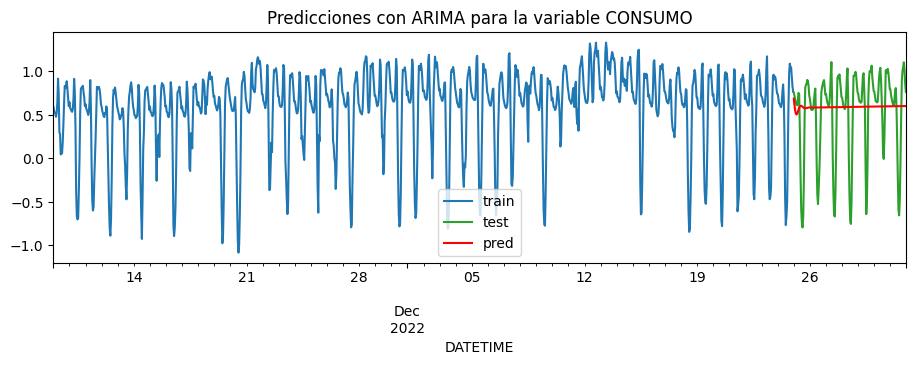

In [60]:
params, metrics, tiempo = modelo_ARIMA(train_val_data, test_data, p, d, q)
tabla_comparacion_modelos = guardar_results(f'ARIMA({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

Los resultados con modelos ARIMA son muy malos, peores incluso que los obtenidos con el modelo baseline. Notar que las predicciones son casi planas. Puede que se deba a la existente estacionalidad de los datos. Deberemos modelar también la componente estacional con SARIMA.

### 5.3. SARIMA (Seasonal ARIMA)

SARIMA es una extensión de ARIMA que incluye componentes estacionales. Ideal para datos que muestran estacionalidad, como el consumo eléctrico que hemos visto que sigue un ciclo diario.

#### 5.3.1. Análisis exploratorio de la serie

Como hemos detectado que nuestras series tienen estacionalidad, será útil realizar una descomposición estacional de series temporales (STL), es decir, descomponer la serie temporal en sus componentes fundamentales para un análisis más detallado:

- La tendencia
- La estacionalidad
- Los residuos

Este análisis puede revelar patrones ocultos y ayudar a identificar la estacionalidad, además de los valores óptimos de los parámetros $P$, $D$, $Q$ y $s$ (y puede llevarse a cabo de manera aditiva o multiplicativa).

In [61]:
def descomposicion_estacional(df):
    res_decompose = seasonal_decompose(df[variable], model='additive', extrapolate_trend='freq')

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))
    res_decompose.observed.plot(ax=axs[0, 0])
    axs[0, 0].set_title('Serie')
    res_decompose.trend.plot(ax=axs[0, 1])
    axs[0, 1].set_title('Tendencia')
    res_decompose.seasonal.plot(ax=axs[1, 0])
    axs[1, 0].set_title('Estacionalidad')
    res_decompose.resid.plot(ax=axs[1, 1])
    axs[1, 1].set_title('Residuos')
    fig.suptitle(f'Descomposición estacional de la serie para la variable {variable}', fontsize=14)
    fig.tight_layout()

    return res_decompose

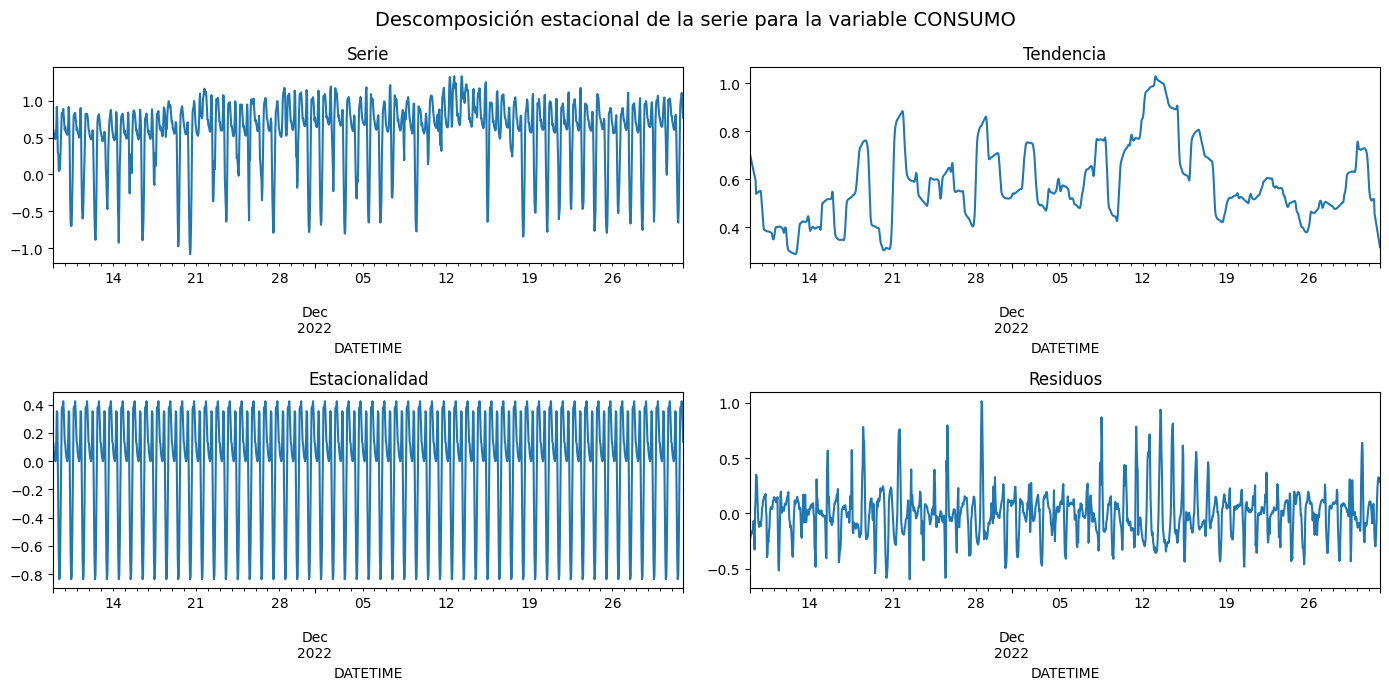

In [62]:
descomposicion_estacional(df_consumo_total)

- La estacionalidad muestra un patrón muy claro con ciclos regulares de 24 horas (lags) en las tres series temporales. De aquí se sigue el valor de s.

In [63]:
s = 24

#### 5.3.2. Creación y entrenamiento del modelo ForecasterSarimax

In [64]:
P, D, Q = 1,1,1

Probaremos a aplicar el modelo SARIMA con las dos librerías que lo tienen tanto skforecast como pmdarima.

In [65]:
params = {
        'order': (p, d, q),
        'seasonal_order': (P, D, Q, s),
        'enforce_stationarity' : False
    }
forecaster_skforecast = ForecasterSarimax(regressor=Sarimax(**params)) #maxiter=200
#forecaster_pmdarima = ForecasterSarimax(regressor=ARIMA(**params))

In [66]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, grafica = False)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 69.04257678985596
Métricas de error: {'MAE': 0.13944996031704687, 'MSE': 0.042493573018423034, 'RMSE': 0.20613969297159399}
--------------------------------


##### Con reentrenamiento

In [67]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, grafica = False, refit = True)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si')

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 361.56975388526917
Métricas de error: {'MAE': 0.14718444114155224, 'MSE': 0.04512909573294312, 'RMSE': 0.21243609799877025}
--------------------------------


##### Con variables exógenas

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 587.9192564487457
Métricas de error: {'MAE': 0.11454091872428039, 'MSE': 0.03309462576284915, 'RMSE': 0.1819192836475813}
--------------------------------


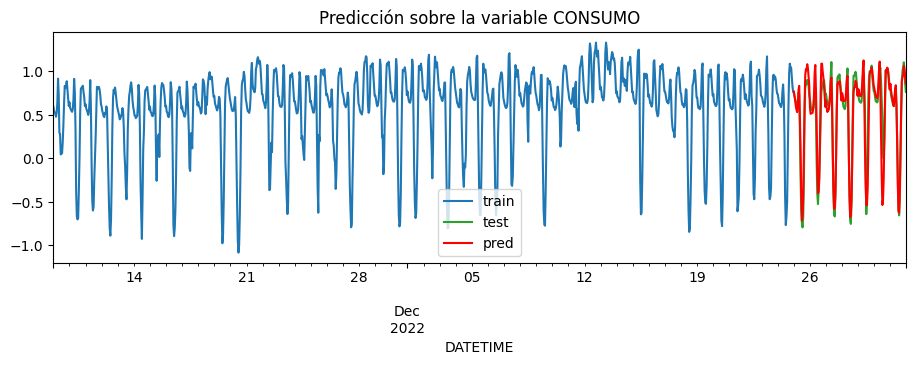

In [68]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, exog_cols = exog_cols)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, var_exog = 'Si')

##### Con reentrenamiento y variables exógenas

In [69]:
metrics, tiempo = backtesting(forecaster_skforecast, df_consumo_total, train_val_data, test_data, grafica = False, refit = True, exog_cols = exog_cols)
tabla_comparacion_modelos = guardar_results(f'ForecasterSarimax(regressor=Sarimax({params})', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si', var_exog = 'Si')

  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

Con el ForecasterSarimax y usando como regresor Sarimax(), hemos conseguido obtener un MAE ligeramente inferior al obtenido con el baseline.

Nos queda margen para ajustar los parámetros, sobre todo en $P$, $D$ y $Q$.

### 5.4. Modelo autoregresivo recursivo con Gradient Boosting Machines (GBM): LGBMRegressor

#### 5.4.1. Creación y entrenamiento del modelo

Se entrena un modelo autorregresivo recursivo (ForecasterAutoreg) con gradient boosting LGBMRegressor como regresor. El parámetro lags es la ventana temporal que se utiliza para predecir la demanda de la hora siguiente, iteremos sobre sus valores. El resto de hiperparámetros del regresor se dejan en sus valores por defecto.

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.24572110176086426
Métricas de error: {'MAE': 0.3387866269528296, 'MSE': 0.2702633533247768, 'RMSE': 0.5198685923623169}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.49239110946655273
Métricas de error: {'MAE': 0.13447371313827755, 'MSE': 0.05224080904110775, 'RMSE': 0.2285624838881214}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.134540319442749
Métricas de error: {'MAE': 0.1252900297928855, 'MSE': 0.04203845840064959, 'RMSE': 0.2050328227397984}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.4880101680755615
Métricas de error: {'MAE': 0.177042362243448, 'MSE': 0.08157397536723385, 'RMSE': 0.2856115812904544}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.4434027671813965
Métricas de error: {'MAE': 0.1400994390841214, 'MSE': 0.040806246565998065, 'RMSE': 0.20200556073038697}
--------------------------------


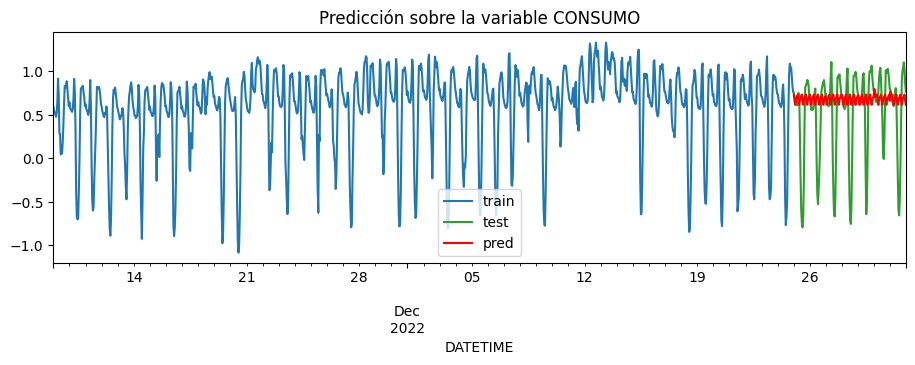

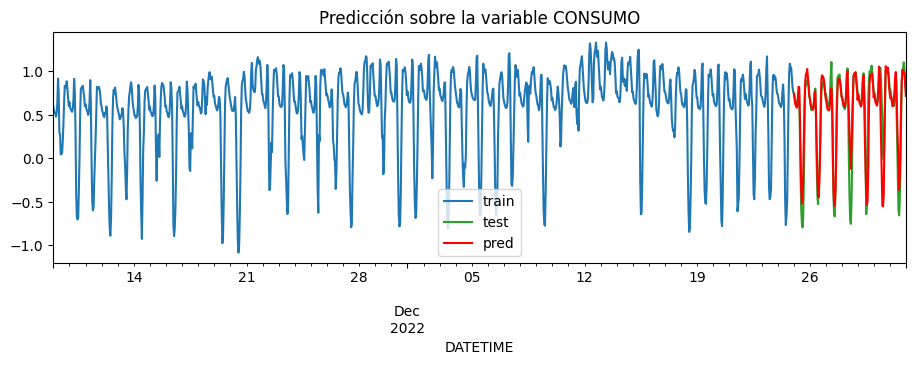

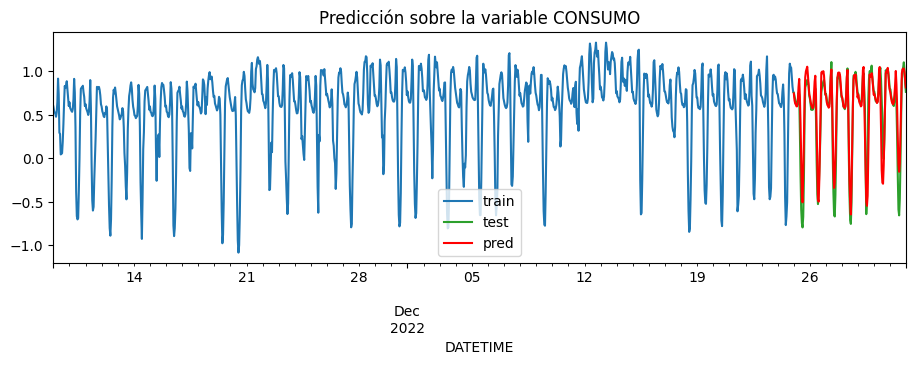

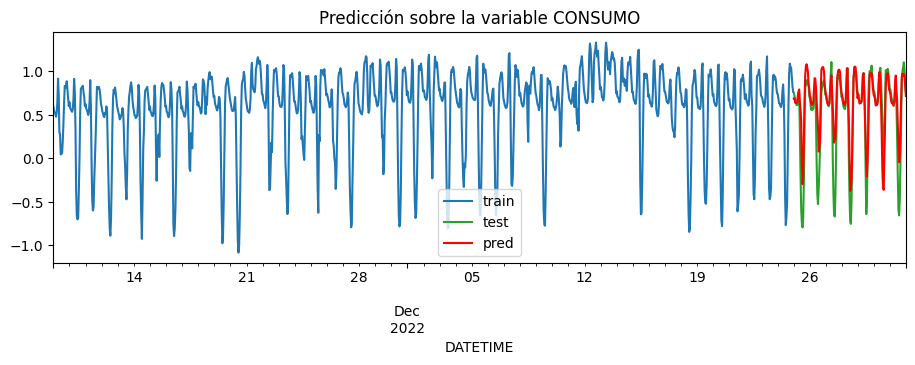

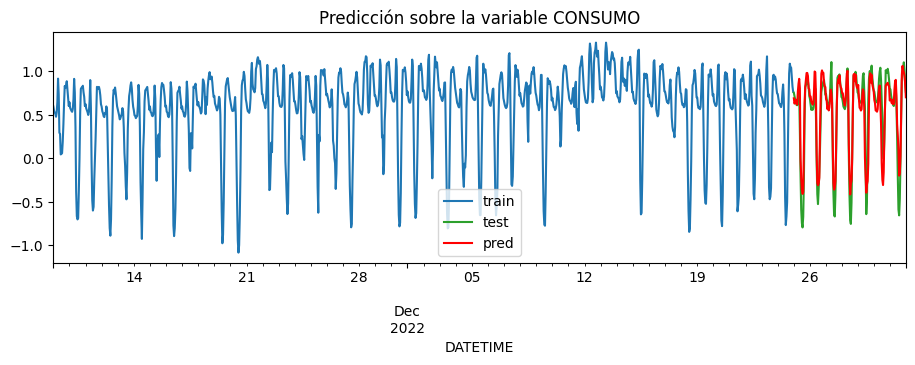

In [70]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data)
  tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

##### Con reentrenamiento

In [71]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data, grafica = False, refit = True)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 6.543682098388672
Métricas de error: {'MAE': 0.38347830400918737, 'MSE': 0.3120368196304962, 'RMSE': 0.5586025596347516}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.0631885528564453
Métricas de error: {'MAE': 0.1309036946593752, 'MSE': 0.04593919033733646, 'RMSE': 0.21433429575627055}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 15.717283725738525
Métricas de error: {'MAE': 0.12036449832284274, 'MSE': 0.0401496374389923, 'RMSE': 0.20037374438531685}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 22.829033136367798
Métricas de error: {'MAE': 0.14650402381064534, 'MSE': 0.05687052778119828, 'RMSE': 0.2384754238515958}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 6.629296064376831
Métricas de error: {'MAE': 0.12576327351258354, 'MSE': 0.04364471315209853, 'RMSE': 0.2089131713226778}
--------------------------------


##### Con variables exógenas

In [72]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data, grafica = False, exog_cols = exog_cols)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.5699143409729004
Métricas de error: {'MAE': 0.13333622525361344, 'MSE': 0.05491508525109885, 'RMSE': 0.234339679207553}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.048959493637085
Métricas de error: {'MAE': 0.09907989425535145, 'MSE': 0.02826330166319649, 'RMSE': 0.16811692854438096}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.619758367538452
Métricas de error: {'MAE': 0.13919396808871487, 'MSE': 0.05190550155231966, 'RMSE': 0.22782778924512184}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.712542772293091
Métricas de error: {'MAE': 0.16677486122314913, 'MSE': 0.06933508159210335, 'RMSE': 0.26331555516547694}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 0.4958469867706299
Métricas de error: {'MAE': 0.14102226732078235, 'MSE': 0.04103515793793043, 'RMSE': 0.20257136504928439}
--------------------------------


##### Con reentrenamiento y con variables exógenas

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.36948561668396
Métricas de error: {'MAE': 0.16434723112924343, 'MSE': 0.0897998137453668, 'RMSE': 0.29966617050539224}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.836278200149536
Métricas de error: {'MAE': 0.10493521084747168, 'MSE': 0.03300212864987106, 'RMSE': 0.18166488006731257}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 16.048518657684326
Métricas de error: {'MAE': 0.11276689756636497, 'MSE': 0.03277540009286576, 'RMSE': 0.1810397748917783}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 24.807969331741333
Métricas de error: {'MAE': 0.13670006063936047, 'MSE': 0.047819158289367385, 'RMSE': 0.2186759206894243}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 5.889265537261963
Métricas de error: {'MAE': 0.1234347399081048, 'MSE': 0.04318948553819186, 'RMSE': 0.20782080150502708}
--------------------------------


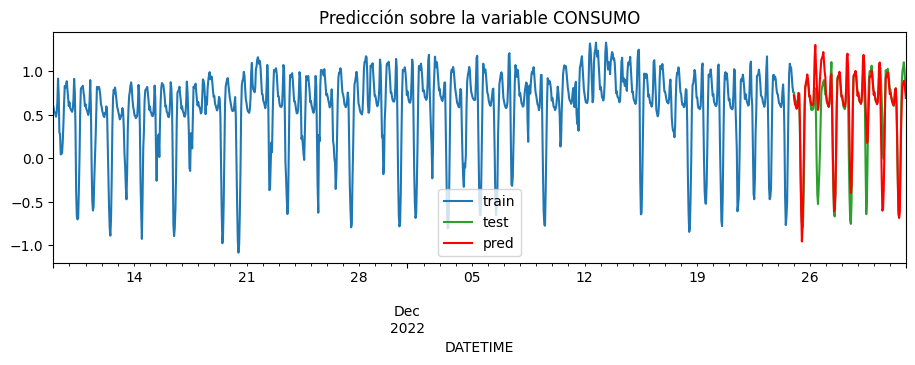

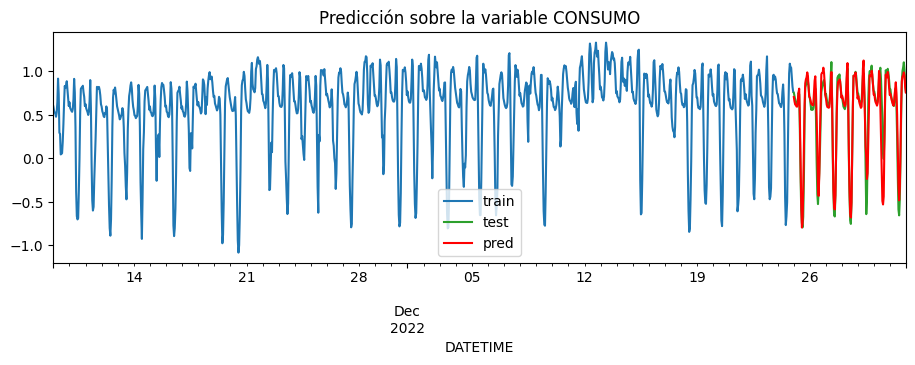

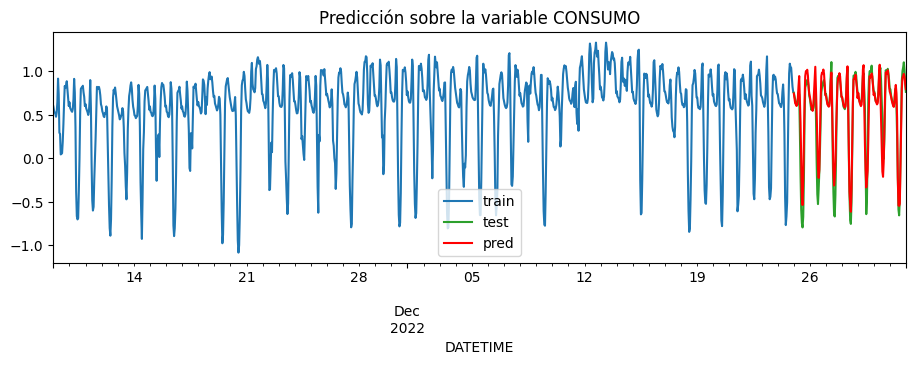

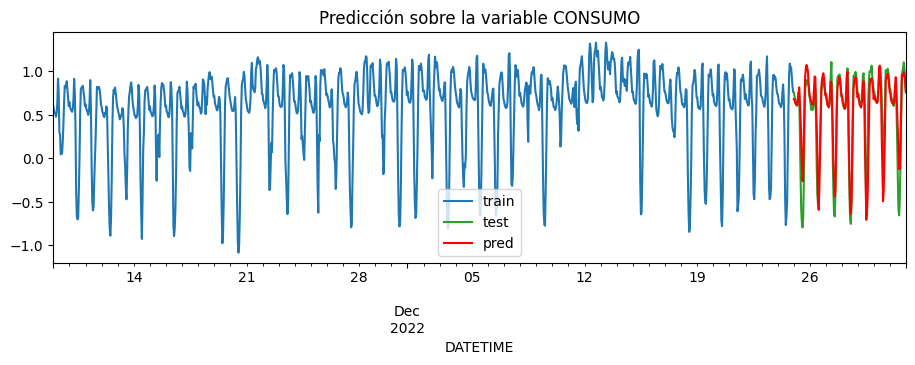

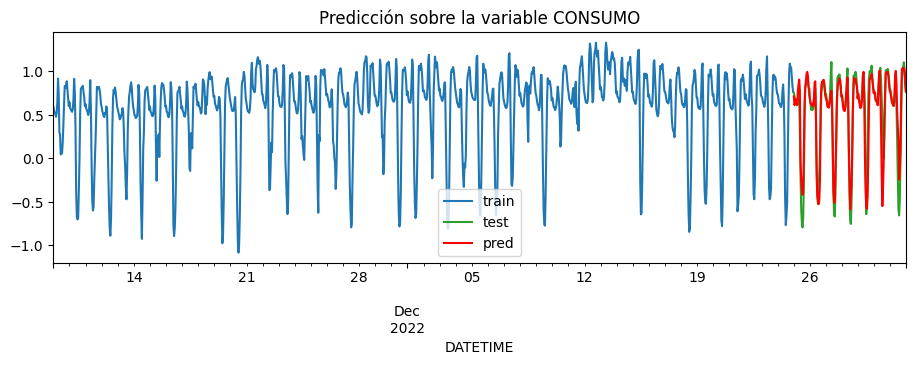

In [73]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_base = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_base, df_consumo_total, train_val_data, test_data, refit = True, exog_cols = exog_cols)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_base.regressor}), lags = {forecaster_ar_base.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

Notar que el error disminuye usando más lags para la predicción y reentrenando los datos según se van haciendo las predicciones.

#### 5.4.5. Explicabilidad

In [74]:
forecaster_1 = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False, exog_cols = exog_cols), lags = 1)
forecaster_24 = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False, exog_cols = exog_cols), lags = 24)
forecaster_1008 = ForecasterAutoreg(regressor = LGBMRegressor(random_state=1, verbose = -1, verbose_eval = False, exog_cols = exog_cols), lags = 1008)

In [75]:
#importancia de los predictores
feature_importances = importancia_features(forecaster_1, df_consumo_total, train_val_data)
feature_importances

feature  %_importance
0                                lag_1         21.00
1                          TEMPERATURA         14.03
2                    %_CIELO_DESPEJADO          7.77
3        poly_HORA_coseno__ORTO_coseno          5.43
4  poly_DIA_SEMANA_coseno__HORA_coseno          4.87
5                          HORA_coseno          4.80
6          poly_HORA_coseno__ORTO_seno          4.77
7                            HORA_seno          4.07
8    poly_DIA_SEMANA_seno__HORA_coseno          4.00
9          poly_HORA_seno__HORA_coseno          3.23

In [76]:
#importancia de los predictores
feature_importances = importancia_features(forecaster_24, df_consumo_total, train_val_data)
feature_importances

feature  %_importance
0              lag_1         10.80
1             lag_24          4.77
2             lag_16          4.50
3             lag_23          4.20
4        TEMPERATURA          3.53
5             lag_22          3.53
6  %_CIELO_DESPEJADO          3.43
7             lag_17          3.40
8              lag_9          2.97
9              lag_3          2.93

In [77]:
#importancia de los predictores
feature_importances = importancia_features(forecaster_1008, df_consumo_total, train_val_data)
feature_importances

feature  %_importance
0  lag_215          3.05
1  lag_504          2.71
2  lag_953          2.71
3   lag_95          2.37
4   lag_73          2.37
5  lag_914          2.03
6  lag_197          2.03
7  lag_216          2.03
8  lag_331          2.03
9  lag_840          1.69

### 5.5. Árboles de Decisión y Random Forest

#### 5.5.1. Creación y entrenamiento del modelo

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 28.10493540763855
Métricas de error: {'MAE': 0.10352845355818471, 'MSE': 0.027515250019911692, 'RMSE': 0.1658772136850378}
--------------------------------


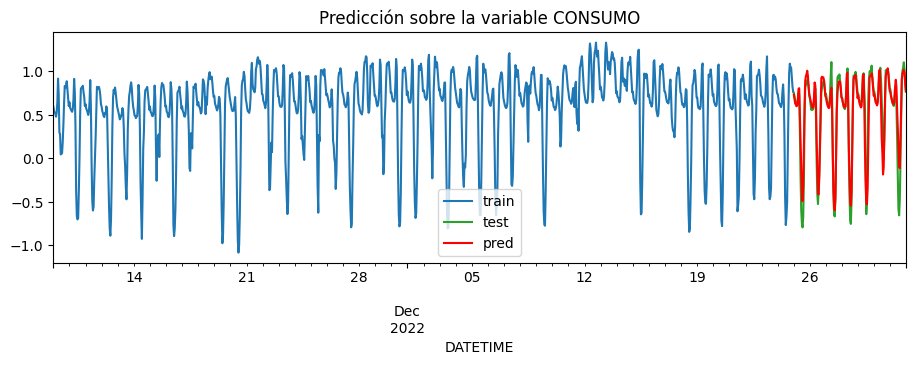

In [78]:
forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 24)
metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, refit = True, exog_cols = exog_cols)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 1.0931782722473145
Métricas de error: {'MAE': 0.38491321531334, 'MSE': 0.31644771188720083, 'RMSE': 0.5625368538035538}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.6745941638946533
Métricas de error: {'MAE': 0.129248793263288, 'MSE': 0.04822587748910362, 'RMSE': 0.21960391045949892}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 12.55495834350586
Métricas de error: {'MAE': 0.10593577638471954, 'MSE': 0.028255997539936323, 'RMSE': 0.16809520379813436}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 16.36106014251709
Métricas de error: {'MAE': 0.192744013037848, 'MSE': 0.11126689788894485, 'RMSE': 0.33356693164782514}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 4.0047056674957275
Métricas de error: {'MAE': 0.1341205237212314, 'MSE': 0.04180145224234587, 'RMSE': 0.2044540345465109}
--------------------------------


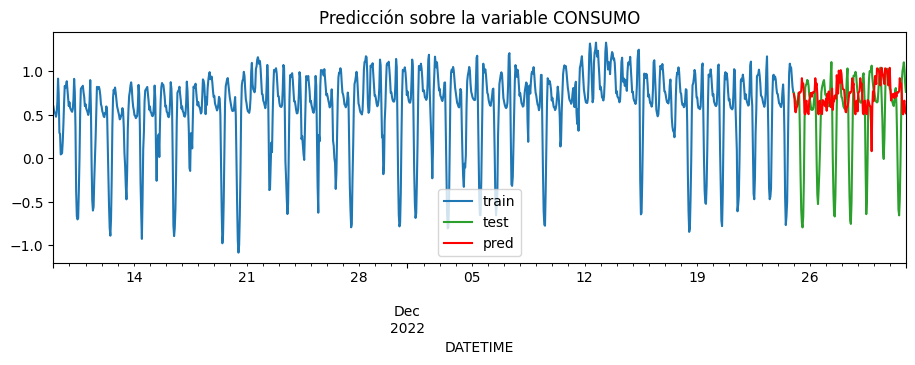

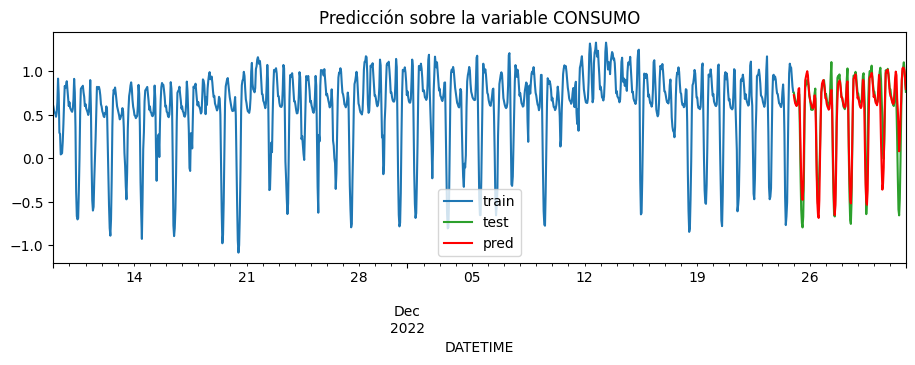

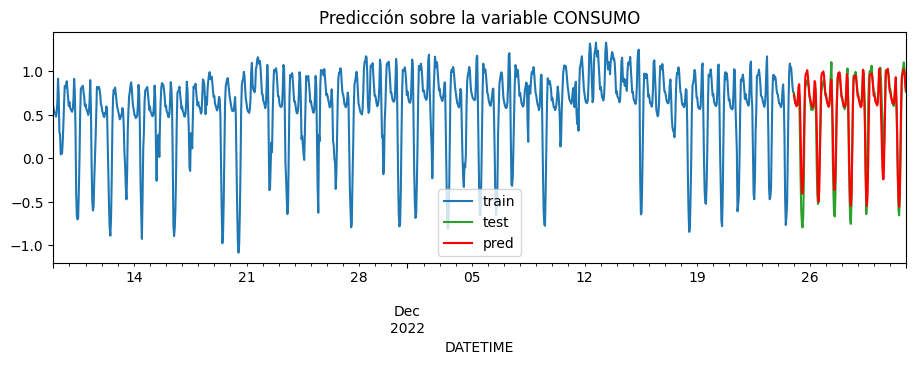

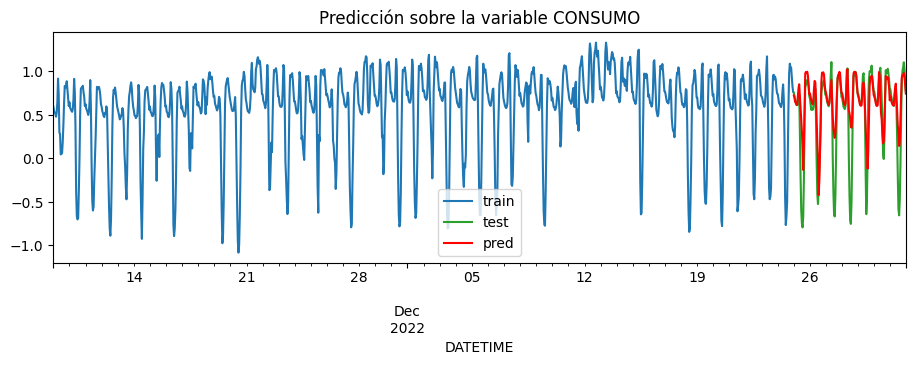

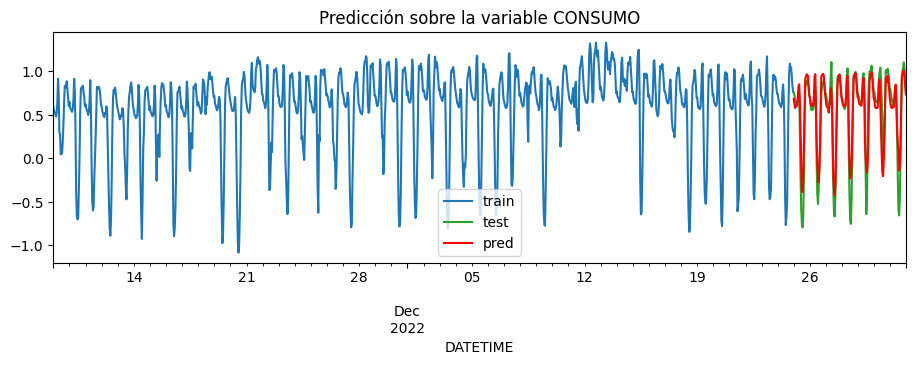

In [79]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data)
  tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

##### Con reentrenamiento

In [80]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, grafica = False, refit = True)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.645629405975342
Métricas de error: {'MAE': 0.4306682481679323, 'MSE': 0.3703037790754642, 'RMSE': 0.6085259066592515}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 14.963062047958374
Métricas de error: {'MAE': 0.13071530666902115, 'MSE': 0.0488078622537773, 'RMSE': 0.22092501500232448}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 72.45237398147583
Métricas de error: {'MAE': 0.11481208627641419, 'MSE': 0.036731996174348656, 'RMSE': 0.1916559317484034}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 115.73966026306152
Métricas de error: {'MAE': 0.14910641893283888, 'MSE': 0.06721601182212943, 'RMSE': 0.2592605095692929}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 43.40069127082825
Métricas de error: {'MAE': 0.12302042704102656, 'MSE': 0.03994690861847051, 'RMSE': 0.19986722747481767}
--------------------------------


##### Con variables exógenas

In [81]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor =  RandomForestRegressor(random_state=123), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, grafica = False, exog_cols = exog_cols)
  #tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos)

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.500455617904663
Métricas de error: {'MAE': 0.09924680491788809, 'MSE': 0.022027735358243854, 'RMSE': 0.14841743616652275}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 5.432048082351685
Métricas de error: {'MAE': 0.11263218332450411, 'MSE': 0.03460366807865747, 'RMSE': 0.18602061197259154}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 14.575694799423218
Métricas de error: {'MAE': 0.10108048906645475, 'MSE': 0.025842029582293074, 'RMSE': 0.16075456317720213}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 17.658018350601196
Métricas de error: {'MAE': 0.19437135609806347, 'MSE': 0.1162550891962947, 'RMSE': 0.34096200550251154}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 3.9580135345458984
Métricas de error: {'MAE': 0.13358852058685033, 'MSE': 0.04124233873522972, 'RMSE': 0.20308209851001077}
--------------------------------


##### Con reentrenamiento y variables exógenas

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 14.144464254379272
Métricas de error: {'MAE': 0.10212529688327747, 'MSE': 0.025523742705260213, 'RMSE': 0.15976151822407114}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 23.95256543159485
Métricas de error: {'MAE': 0.10352845355818471, 'MSE': 0.027515250019911692, 'RMSE': 0.1658772136850378}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 83.852383852005
Métricas de error: {'MAE': 0.1102097971481547, 'MSE': 0.03480338365705845, 'RMSE': 0.18655664999420002}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 137.5732295513153
Métricas de error: {'MAE': 0.1623563743451645, 'MSE': 0.0810491217426996, 'RMSE': 0.28469127444075204}
--------------------------------


  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 43.118874073028564
Métricas de error: {'MAE': 0.12365070957678495, 'MSE': 0.04111355568851796, 'RMSE': 0.20276477921107985}
--------------------------------


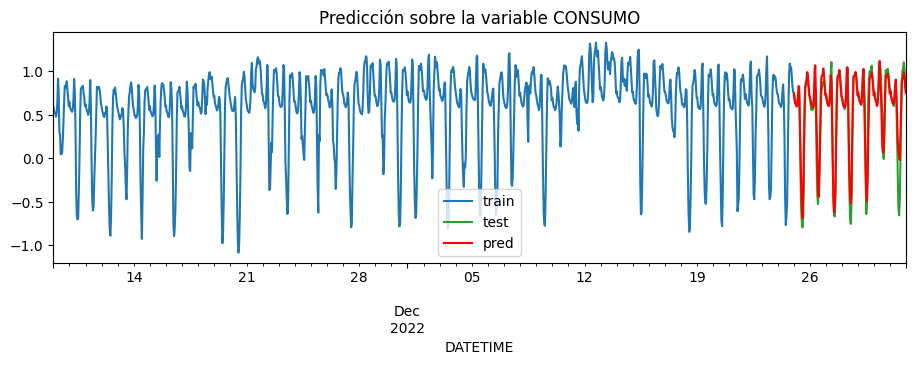

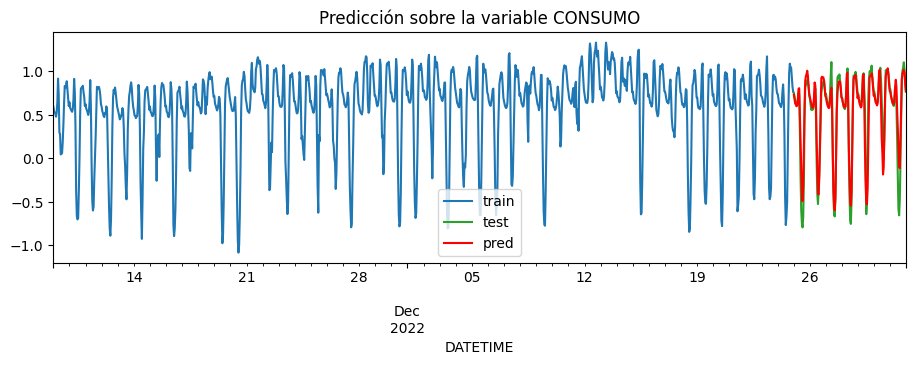

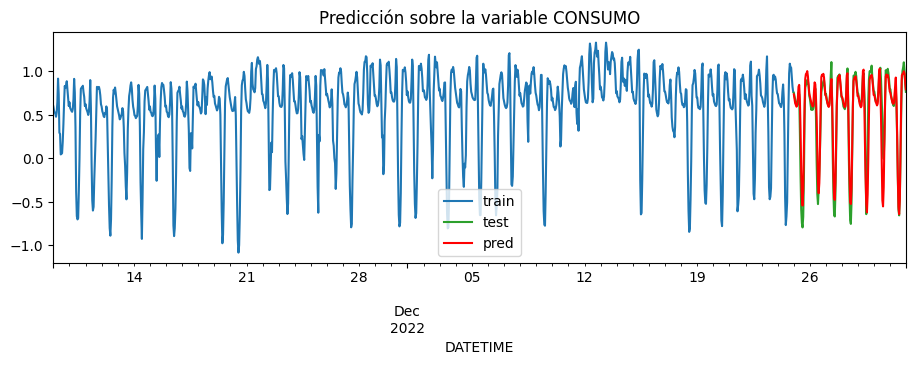

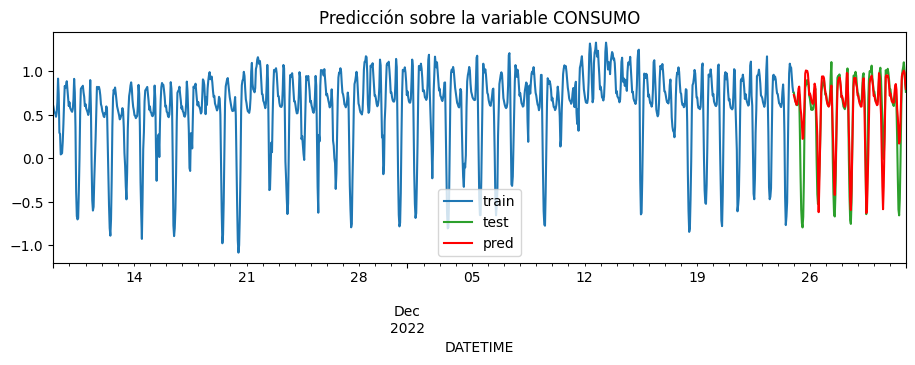

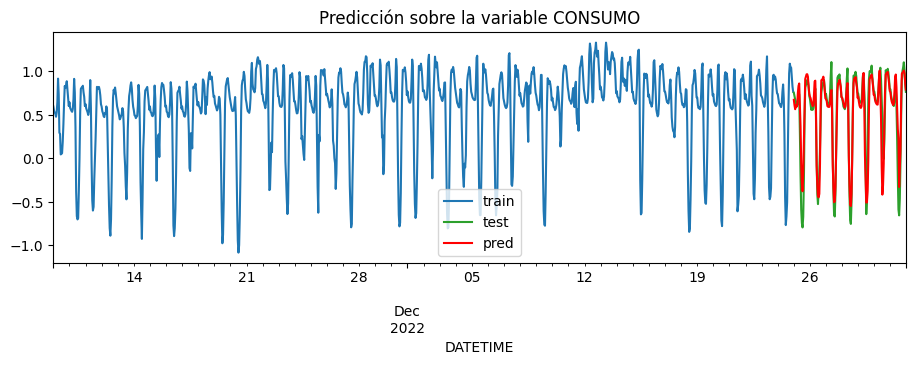

In [82]:
for i in [1, 24, 168, 720, 1008]:
  forecaster_ar_rf = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123), lags = i)
  metrics, tiempo = backtesting(forecaster_ar_rf, df_consumo_total, train_val_data, test_data, refit = True, exog_cols = exog_cols)
  tabla_comparacion_modelos = guardar_results(f'ForecasterAutoreg(regressor = {forecaster_ar_rf.regressor}), lags = {forecaster_ar_rf.lags}', tiempo, metrics['MAE'], metrics['MSE'], metrics['RMSE'], tabla_comparacion_modelos, refit = 'Si', var_exog = 'Si')

### 5.7. Prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9mzcfsqx/pksuxone.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9mzcfsqx/nmjt8edw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24916', 'data', 'file=/tmp/tmp9mzcfsqx/pksuxone.json', 'init=/tmp/tmp9mzcfsqx/nmjt8edw.json', 'output', 'file=/tmp/tmp9mzcfsqx/prophet_modelau96rfkb/prophet_model-20240709121511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:15:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:15:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Métricas de error: MAE: 0.17882121621701308, MSE: 0.05566400386435003, RMSE: 0.23593220183847316
2.473888397216797


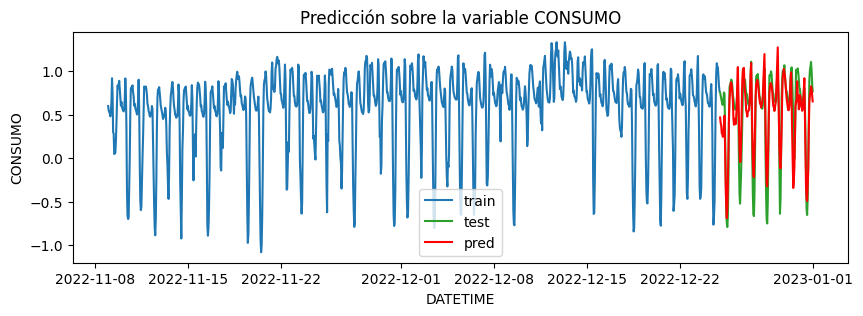

In [83]:
prophet_train = train_val_data[[variable] + exog_cols].reset_index().rename(columns={'DATETIME': 'ds', variable: 'y'})
prophet_test = test_data[[variable] + exog_cols].reset_index().rename(columns={'DATETIME': 'ds', variable: 'y'})

inicio = time.time()
m = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_mode='additive', changepoint_prior_scale=0.1,
    seasonality_prior_scale=10.0)

for i in exog_cols:
    m.add_regressor(i)
m.add_country_holidays(country_name='ES')  # Usa el país correspondiente a tus datos
m.fit(prophet_train)

future = m.make_future_dataframe(periods=len(prophet_test), freq='H', include_history=True)
for col in exog_cols:
    future[col] = pd.concat([train_val_data[col], test_data[col]]).reset_index(drop=True)

forecast = m.predict(future)
forecast_test = forecast[-len(prophet_test):]
fin = time.time()
tiempo = fin - inicio
mae = mean_absolute_error(prophet_test['y'], forecast_test['yhat'])
mse = mean_squared_error(prophet_test['y'], forecast_test['yhat'])
rmse = mse ** 0.5
print(f'Métricas de error: MAE: {mae}, MSE: {mse}, RMSE: {rmse}')
print(tiempo)

plt.figure(figsize=(10, 3))
plt.plot(prophet_train['ds'], prophet_train['y'], label='train', color = '#1f77b4')
plt.plot(prophet_test['ds'], prophet_test['y'], label='test', color = '#2ca02c')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='pred', color = '#FF0000')
plt.xlabel('DATETIME')
plt.ylabel(variable)
plt.title(f'Predicción sobre la variable {variable}')
plt.legend()
plt.show()

## 6. Evaluación de los modelos

In [84]:
tabla_comparacion_modelos = tabla_comparacion_modelos.sort_values(by='MAE', ascending = True)
tabla_comparacion_modelos.to_csv(f'/content/drive/MyDrive/TFM/tabla_comparacion_modelos_{variable}.csv')

In [85]:
tabla_comparacion_modelos.sort_values(by='MAE', ascending = True)

Modelo  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ForecasterEquivalentDate({'offset': <DateOffset: days=7>, 'n_offsets': 1})   
19                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Guardamos las predicciones del mejor modelo para poder utilizarlas.

  0%|          | 0/7 [00:00<?, ?it/s]

Tiempo de ejecución: 2.8408944606781006
Métricas de error: {'MAE': 0.09924680491788809, 'MSE': 0.022027735358243854, 'RMSE': 0.14841743616652275}
--------------------------------


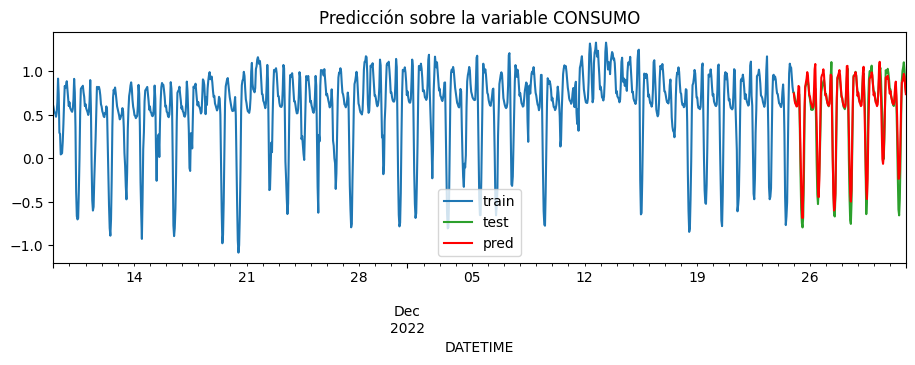

In [89]:
  mejor_modelo = ForecasterAutoreg(regressor =  RandomForestRegressor(random_state=123), lags = 1)
  metrics, tiempo, predictions = backtesting(mejor_modelo, df_consumo_total, train_val_data, test_data, exog_cols = exog_cols)

In [90]:
predictions.to_csv('/content/drive/MyDrive/TFM/predictions_PROVINCIA_CONSUMO.csv', index=True)